In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download NLTK stopwords if you haven't already
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SSC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SSC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv('C:/Users/SSC/OneDrive/Desktop/Task 2/new_dataset.csv')

In [4]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [5]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [6]:
df = df[['text']]

In [7]:
df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [8]:
df.shape

(11020, 1)

In [9]:
df.drop_duplicates(inplace = True)

In [10]:
df.shape

(11013, 1)

In [11]:
df.isnull().sum()

text    0
dtype: int64

In [12]:
def data_processing(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'RT[\s]+', '', text)  # Remove retweets
    text = re.sub(r'https?:\/\/\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'https\S+|www\S+https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = text.lower()

    text_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_text = [w for w in text_tokens if not w in stop_words]

    return ' '.join(filtered_text)

In [13]:
df.text = df['text'].apply(data_processing)

In [14]:
df.shape

(11013, 1)

In [15]:
df = df.drop_duplicates('text')

In [16]:
df.shape

(10481, 1)

In [17]:
stemmer = PorterStemmer()

In [18]:
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [19]:
df['text'] = df['text'].apply(lambda x: stemming(x))

In [20]:
df.head()

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine whereareallthesickpeople ...


In [21]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [22]:
df['polarity'] = df['text'].apply(polarity)

In [23]:
df.head()

,text,polarity
0,folks said daikon paste could treat cytokine s...,0.0
1,world wrong side history year hopefully bigges...,-0.5
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0
3,facts immutable senator even youre ethically s...,0.1
4,explain need vaccine whereareallthesickpeople ...,0.0


In [24]:
def sentiment(label):
    if label < 0:
        return 'Negative'
    elif label > 0:
        return 'Positive'
    elif label == 0:
        return 'Neutral'

In [25]:
df['Sentiment'] = df['polarity'].apply(sentiment)

In [26]:
df.head()

,text,polarity,Sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
3,facts immutable senator even youre ethically s...,0.1,Positive
4,explain need vaccine whereareallthesickpeople ...,0.0,Neutral


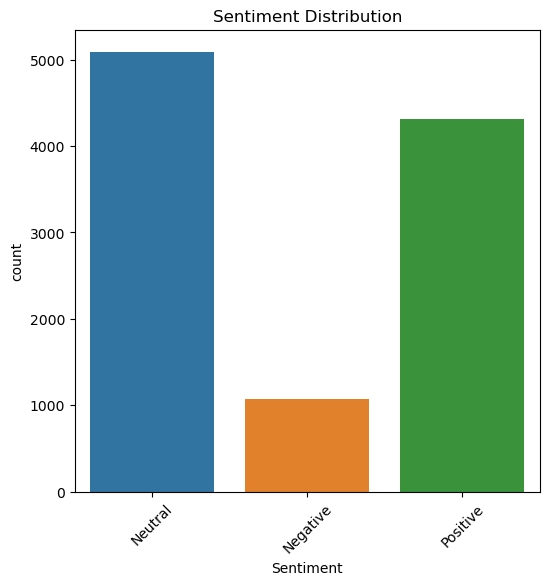

In [27]:
sentiment_counts = df['Sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 6))
sns.countplot(x='Sentiment', data = df)
plt.title('Sentiment Distribution')
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'Sentiment Distribution')

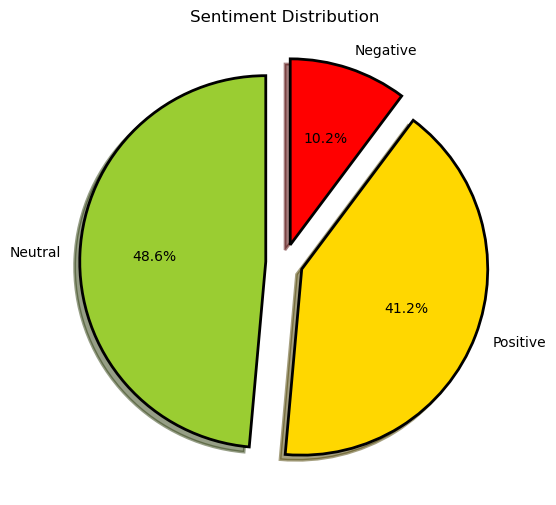

In [28]:
fig = plt.figure(figsize=(6,7))
colors = ('yellowgreen', 'gold', 'red')
wp = {'linewidth': 2, 'edgecolor': 'black'}
tags = df['Sentiment'].value_counts()
explode = (0.1, 0.1, 0.1)
tags.plot(kind = 'pie', autopct = '%1.1f%%', shadow = True, colors = colors, startangle = 90,
          wedgeprops = wp, explode = explode, label = '')
plt.title("Sentiment Distribution")

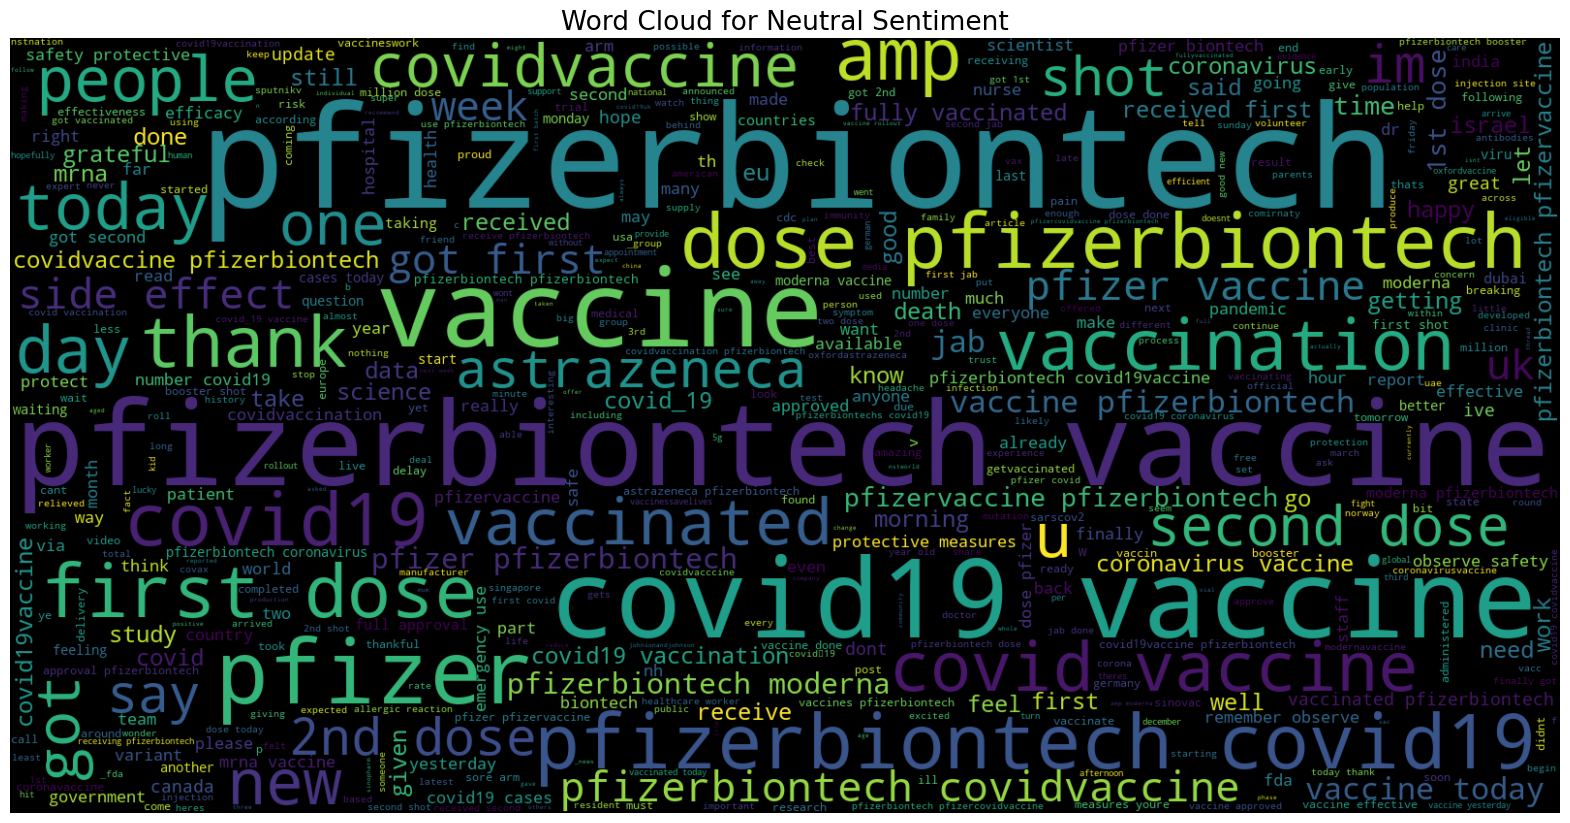

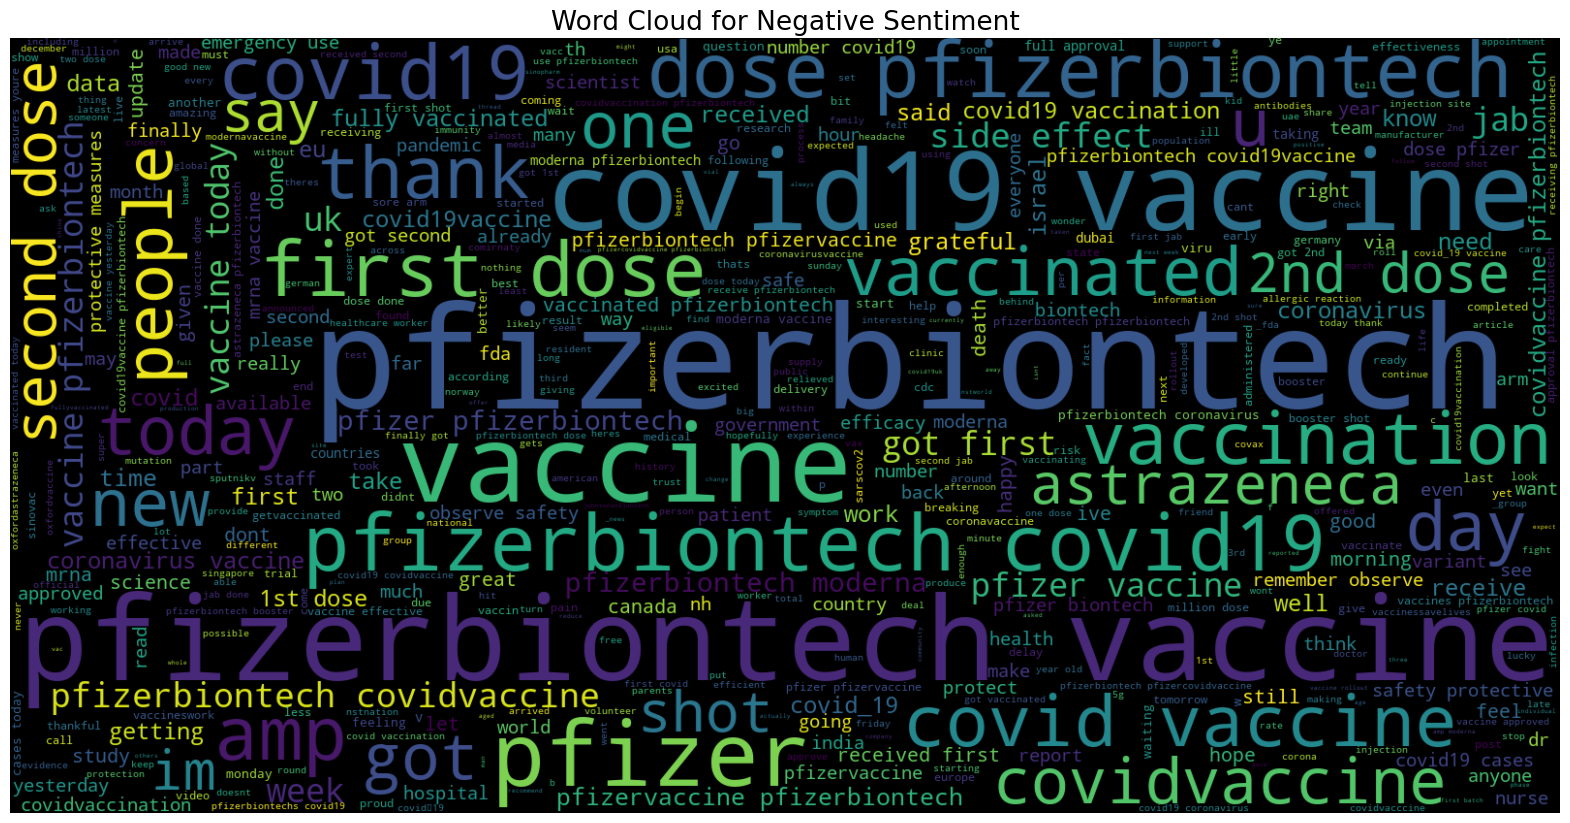

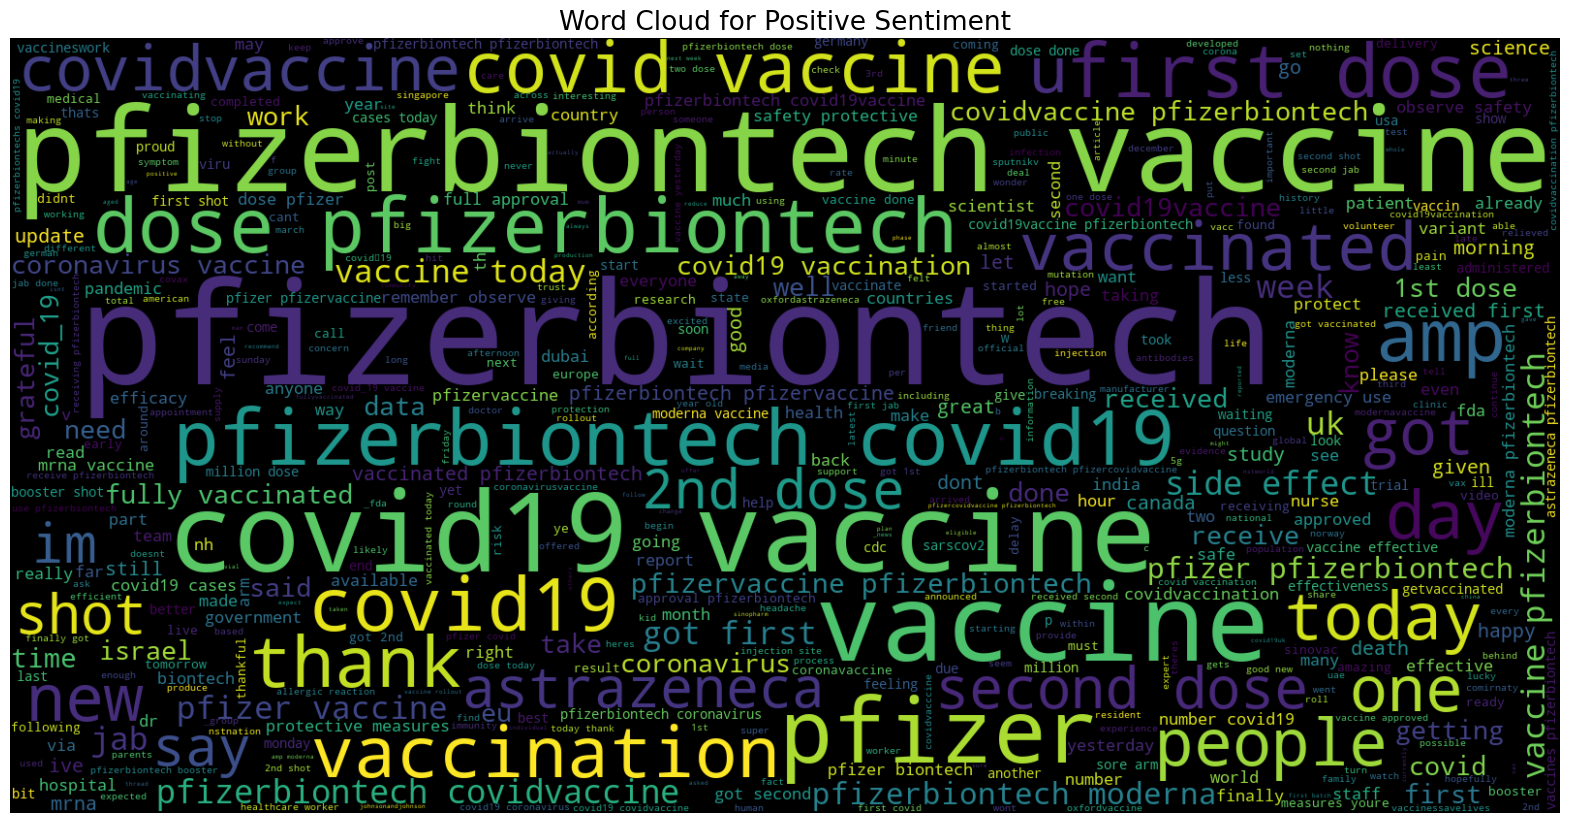

In [29]:
sentiments = df['Sentiment'].unique()

for sentiment in sentiments:
    text = ' '.join(df['text'])
    plt.figure(figsize=(20, 15), facecolor = None)
    wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment', fontsize=19)
    plt.axis('off')
    plt.show()

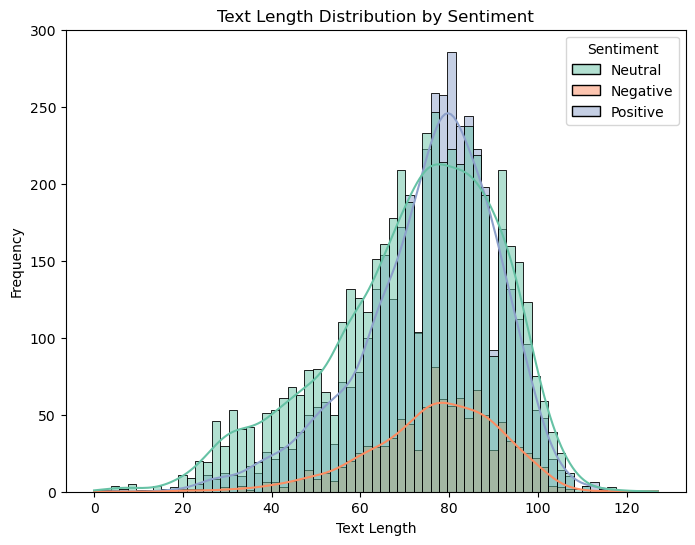

In [30]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x=df['text'].str.len(), hue='Sentiment', kde=True, palette='Set2')
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [31]:
word_freq = Counter(text.split())
common_words = word_freq.most_common(20)  # Get the 20 most common words
print('Top 20 Most Common Words:')
for word, freq in common_words:
    print(f'{word}: {freq}')

Top 20 Most Common Words:
pfizerbiontech: 6005
vaccine: 4101
covid19: 2306
dose: 1433
pfizer: 1301
first: 1161
today: 798
got: 784
vaccines: 735
vaccinated: 728
covidvaccine: 701
covid: 697
vaccination: 590
get: 557
second: 550
amp: 473
pfizervaccine: 461
moderna: 442
2nd: 432
people: 431


In [32]:
texts = df['text'].tolist()
labels = df['Sentiment'].tolist()

In [33]:
# Map labels to numerical values
label_mapping = {'Positive': 0, 'Negative': 1, 'Neutral': 2}
labels = [label_mapping.get(label, -1) for label in labels]

# Filter out samples with labels not found in the mapping
filtered_texts = []
filtered_labels = []
for text, label in zip(texts, labels):
    if label != -1:
        filtered_texts.append(text)
        filtered_labels.append(label)


In [34]:
train_texts, test_texts, train_labels, test_labels = train_test_split(filtered_texts, filtered_labels, test_size=0.2, random_state=42)

In [35]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training and testing texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

In [36]:
from torch.utils.data import TensorDataset, DataLoader
# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [37]:
# Load the pre-trained BERT model for sequence classification with 3 labels
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [38]:
# Training loop
num_epochs = 3  # Adjust the number of training epochs as needed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

Epoch 1/3, Loss: 0.5966
Epoch 2/3, Loss: 0.2403
Epoch 3/3, Loss: 0.1241


In [39]:
from sklearn.metrics import accuracy_score

# ... (previous code)

# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Generate a classification report
classification_rep = classification_report(all_labels, all_preds)

print(f"Accuracy: {accuracy*100:.2f}%")
print()
print(classification_rep)


Accuracy: 94.28%

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       832
           1       0.80      0.83      0.82       220
           2       0.96      0.98      0.96      1045

    accuracy                           0.94      2097
   macro avg       0.91      0.91      0.91      2097
weighted avg       0.94      0.94      0.94      2097



In [40]:
model.save_pretrained('./bert_sentiment_model')